<a href="https://colab.research.google.com/github/Sky0307/2022DLProject/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import h5py
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [ ]:
# link to download the zip format of the data
download_data_url = "https://drive.google.com/file/u/1/d/1X3amA5n6RjYoY5QHdFfYOFfh9w3zbEU4/view"

# link to the actual dataset
data_url = "https://drive.google.com/drive/folders/1OUdNIIV1SD7eavLNWC8a3mpxqnGjL1Kb?usp=sharing"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = "drive/MyDrive/datasets"

# Default Params

In [ ]:
class Parameters:
    def __init__(self):
        self.batch_size = None
        self.label_size = 10
        self.epoch_num = None
        self.sample_rate = 16000
        self.use_cuda = True
        self.cuda = torch.cuda.is_available() and self.use_cuda
        self.log_step = None
        self.dataset_len = None
        self.dictionary = {0: 'pop',
                           1: 'metal',
                           2: 'disco',
                           3: 'blues',
                           4: 'reggae',
                           5: 'classical',
                           6: 'rock',
                           7: 'hiphop',
                           8: 'country',
                           9: 'jazz'}
        self.r_dictionary = {'pop': 0,
                             'metal': 1,
                             'disco': 2,
                             'blues': 3,
                             'reggae': 4,
                             'classical': 5,
                             'rock': 6,
                             'hiphop': 7,
                             'country': 8,
                             'jazz': 9}

        # On pure GTZAN dataset
        self.TRAIN_DATA_PATH = directory + '/train.h5'
        self.VAL_DATA_PATH = directory + '/valid.h5'
        self.TEST_DATA_PATH = directory + '/test.h5'

        # On hybrid dataset
        self.A_TRAIN_DATA_PATH = directory + '/fin_train.h5'
        self.A_VAL_DATA_PATH = directory + '/fin_valid.h5'
        self.A_TEST_DATA_PATH = directory + '/fin_test.h5'

        # On hybrid dataset
        self.LA_TRAIN_DATA_PATH = directory + '/l_train.h5'
        self.LA_VAL_DATA_PATH = directory + '/l_valid.h5'
        self.LA_TEST_DATA_PATH = directory + '/l_test.h5'

        self.MODEL_SAVE_FOLD = directory + '/model/'
        self.LOG_SAVE_FOLD = directory + '/log/'

        if self.cuda:
            self.kwargs = {'num_workers': 1, 'pin_memory': True}
        else:
            self.kwargs = {}

        self.learning_rate = 1e-5

    def __str__(self):
        out_string = "The Batch Size is {0}\n" \
                     "The Label Size is {1}\n" \
                     "The Epoch Num is {2}\n" \
                     "The Cuda is set to {3}\n" \
                     "The log step is {4}".format(self.batch_size,
                                                  self.label_size,
                                                  self.epoch_num,
                                                  self.cuda,
                                                  self.log_step)
        return out_string

In [ ]:
Para = Parameters()
Para.learning_rate = 1e-5
Para.batch_size = 20
Para.epoch_num = 50
print(Para)

The Batch Size is 20
The Label Size is 10
The Epoch Num is 50
The Cuda is set to True
The log step is None


In [ ]:
class TorchData(Dataset):

    def __init__(self, dataset_path):
        """
        Take the h5py dataset
        """
        super(TorchData, self).__init__()
        self.dataset = h5py.File(dataset_path, 'r')
        self.mel = self.dataset['mel']
        self.tag = self.dataset['tag']

        self.len = self.mel.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        mel = self.mel[index].astype(np.float32)
        mel = np.reshape(mel, (1, mel.shape[0], mel.shape[1]))
        mel = torch.from_numpy(mel)
        tag = torch.from_numpy(self.tag[index].astype(np.float32))
        sample = {"mel": mel, "tag": tag}

        return sample


# define the data loaders
def torch_dataset_loader(dataset, batch_size, shuffle, kwargs):
    """
    take the h5py dataset
    """
    loader = DataLoader(TorchData(dataset),
                        batch_size=batch_size,
                        shuffle=shuffle,
                        **kwargs)
    return loader

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        cov1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(cov1.weight)
        self.convBlock1 = nn.Sequential(cov1,
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        cov2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(cov2.weight)
        self.convBlock2 = nn.Sequential(cov2,
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        cov3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(cov3.weight)
        self.convBlock3 = nn.Sequential(cov3,
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4))

        cov4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(cov4.weight)
        self.convBlock4 = nn.Sequential(cov4,
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4))

        self.fcBlock1 = nn.Sequential(nn.Linear(in_features=2048, out_features=1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.5))

        self.fcBlock2 = nn.Sequential(nn.Linear(in_features=1024, out_features=256),
                                      nn.ReLU(),
                                      nn.Dropout(0.5))

        self.output = nn.Sequential(nn.Linear(in_features=256, out_features=10),
                                    nn.Softmax(dim=1))

    def forward(self, inp):
        out = self.convBlock1(inp)
        out = self.convBlock2(out)
        out = self.convBlock3(out)
        out = self.convBlock4(out)

        out = out.view(out.size()[0], -1)
        out = self.fcBlock1(out)
        out = self.fcBlock2(out)
        out = self.output(out)
        return out

# Util function

In [ ]:
def accuracy_function(output, target):
    # shape: (batch, labels)
    f_output = output.cpu() if Para.cuda else output.clone()
    f_target = target.cpu() if Para.cuda else target.clone()

    output_res = f_output.detach().numpy()
    target_res = f_target.detach().numpy()
    predicted_index = np.argmax(output_res, axis=1)

    target_index = np.argmax(target_res, axis=1)

    # counter
    correct = np.sum(predicted_index == target_index)
    accuracy = correct / (output.shape[0])
    return accuracy


def matrix_tuple(output, target):
    f_output = output.cpu() if Para.cuda else output.clone()
    f_target = target.cpu() if Para.cuda else target.clone()

    output_res = f_output.detach().numpy()
    target_res = f_target.detach().numpy()
    predicted_index = np.argmax(output_res, axis=1)
    target_index = np.argmax(target_res, axis=1)
    result_list = [[int(predicted_index[i]), int(target_index[i])] for i in range(len(predicted_index))]
    return result_list


def bce_loss(output, target):
    loss_mlp = nn.BCELoss()
    loss = loss_mlp(output, target)
    return loss

# Helper functions for training

In [ ]:
def train(model, epoch, train_loader, optimizer, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(train_loader)
    _index = 0

    for _index, data in enumerate(train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        loss_value = bce_loss(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def validate_test(model, epoch, use_loader):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = use_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            loss_value = bce_loss(predicted, target)
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy


def record_matrix(model, use_loader, log_name):
    model = model.eval()
    data_loader_use = use_loader
    _index = 0
    result = list()
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)
            m_tuple_list = matrix_tuple(predicted, target)
            result += m_tuple_list

    print('End of Matrix Record, Save file in {0}'.format(Para.LOG_SAVE_FOLD + log_name))
    print('-' * 99)
    with open(Para.LOG_SAVE_FOLD + log_name, 'w+') as f:
        json.dump(result, f)
    return


def main_train(model, train_loader, valid_loader, log_name, save_name, lr=Para.learning_rate, epoch_num=Para.epoch_num):
    Para.dataset_len = len(train_loader)
    Para.log_step = len(train_loader) // 4
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    t_loss, t_accu, v_loss, v_accu = [], [], [], []

    decay_cnt = 0
    for epoch in range(1,  epoch_num + 1):
        if Para.cuda:
            model.cuda()
        train_loss, train_accuracy = train(model, epoch, train_loader, optimizer)
        validation_loss, validation_accuracy = validate_test(model, epoch, use_loader=valid_loader)

        t_loss.append(train_loss)
        t_accu.append(train_accuracy)

        v_loss.append(validation_loss)
        v_accu.append(validation_accuracy)

        # use accuracy to find the best model
        if np.max(t_accu) == t_accu[-1]:
            print('***Found Best Training Model***')
        if np.max(v_accu) == v_accu[-1]:
            with open(Para.MODEL_SAVE_FOLD + save_name, 'wb') as f:
                torch.save(model.cpu().state_dict(), f)
                print('***Best Validation Model Found and Saved***')

        print('-' * 99)

        # Use BCE loss value for learning rate scheduling
        decay_cnt += 1

        if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
            scheduler.step()
            decay_cnt = 0
            print('***Learning rate decreased***')
            print('-' * 99)

    build_dict = {
        "train_loss": t_loss,
        "train_accu": t_accu,
        "valid_loss": v_loss,
        "valid_accu": v_accu,
    }

    with open(Para.LOG_SAVE_FOLD + log_name, 'w+') as lf:
        json.dump(build_dict, lf)

    return build_dict

In [ ]:
train_loader = torch_dataset_loader(Para.A_TRAIN_DATA_PATH, Para.batch_size, True, Para.kwargs)
validation_loader = torch_dataset_loader(Para.A_VAL_DATA_PATH, Para.batch_size, False, Para.kwargs)
test_loader = torch_dataset_loader(Para.A_TEST_DATA_PATH, Para.batch_size, False, Para.kwargs)

# Setting Parameters

In [ ]:
CNN = CnnModel()
res = main_train(model=CNN, 
                 train_loader=train_loader,
                 valid_loader=validation_loader,
                 log_name='CnnModel.json',
                 save_name='CnnModel.pt',
                 lr=Para.learning_rate,
                 epoch_num=Para.epoch_num)

Epoch  1 | 123/495 batches | 70.17ms/ batch | BCE: 0.3087 | Accuracy: 21.71% |
Epoch  1 | 246/495 batches | 67.69ms/ batch | BCE: 0.3008 | Accuracy: 25.16% |
Epoch  1 | 369/495 batches | 66.95ms/ batch | BCE: 0.2943 | Accuracy: 28.13% |
Epoch  1 | 492/495 batches | 66.59ms/ batch | BCE: 0.2890 | Accuracy: 30.24% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 32.97s | BCE: 0.2889 | Accuracy: 30.34% |
End of validation epoch   1 | time:  1.40s | BCE: 0.2494 | Accuracy: 40.52% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 | 123/495 batches | 66.00ms/ batch | BCE: 0.2604 | Accuracy: 41.34% |
Epoch  2 | 246/495 batches | 65.84ms/ batch | BCE: 0.2563 | Accuracy: 42.07

## Visualization

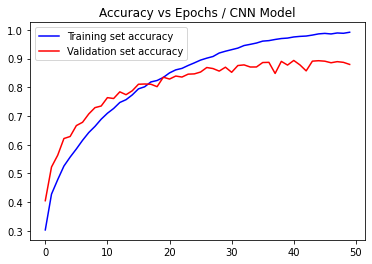

In [ ]:
plt.figure()
plt.plot(res['train_accu'], c='b', label='Training set accuracy')
plt.plot(res['valid_accu'], c='r', label='Validation set accuracy')
plt.title('Accuracy vs Epochs / CNN Model')
plt.legend()
plt.show()

# Testing on Song

In [17]:
class MusicDealer:
    def __init__(self, weight_path, model, size=128):
        self.model = model
        self.index = size
        self.remove = 15  # remove the first and last 15 s
        self.model.load_state_dict(torch.load(weight_path, map_location='cpu'))
        self.model = model.eval()

    def audio_loader(self, audio_path):
        y, _ = librosa.load(audio_path, mono=True, sr=Para.sample_rate)
        y = y[self.remove*Para.sample_rate: -1*self.remove*Para.sample_rate]
        y = librosa.feature.melspectrogram(y=y, sr=Para.sample_rate, n_mels=self.index).T
        y = librosa.power_to_db(y)
        if not y.shape[0] % self.index == 0:
            y = y[:-1 * (y.shape[0] % self.index)]
        chunk_num = int(y.shape[0] / self.index)
        mel_chunks = np.split(y, chunk_num)
        return mel_chunks

    def get_genre(self, audio_path):
        print("Test on {0}".format(audio_path.split('/')[-1]))
        tag_list = dict()
        idx_list = [x for x in range(10)]
        for idx in idx_list:
            tag_list[idx] = 0

        for i, data in enumerate(self.audio_loader(audio_path)):
            with torch.no_grad():
                data = torch.FloatTensor(data).view(1, 1, self.index, self.index)  # resize to fit it in model
                predict = self.model(data)
                score, tag = predict.max(1)
            tag_list[int(tag)] = tag_list.get(int(tag)) + float(score)

        _sum = sum([tag_list.get(key) for key in tag_list])

        idx_list.sort(key=lambda x: -1 * tag_list.get(x))
        tmp = dict()
        for i in idx_list:
            current_genre = Para.dictionary.get(i)
            current_score = tag_list.get(i) / _sum * 100
            tmp[i] = current_score
            if current_score == 0:
                break
            print('Genre {0}: {1}%'.format(current_genre, round(current_score, 2)))
        return idx_list[0], idx_list[1], idx_list[2], tmp


In [18]:
WEIGHT_PATH = directory + "/model/"
cnn_dealer = MusicDealer(WEIGHT_PATH + "CnnModel.pt", CnnModel())